# Retrieval Dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import json
import numpy as np
from transformers import AutoTokenizer, AutoModel, AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from dotenv import load_dotenv
import os
import huggingface_hub as hf_hub
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from IPython.display import clear_output
import multiprocessing as mp
from typing import Dict, List, Tuple, Optional, Any

In [ ]:
# Login huggingface
load_dotenv()
hf_hub.login(os.getenv('HF_TOKEN'))

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(device)

cuda


In [ ]:
class MeetingRetrievalDataset(Dataset):
    def __init__(
        self, 
        json_files: List[str], 
        encoder=None, 
        max_length: int = 4096
    ):
        """
        Dataset for meeting retrieval model training and evaluation
        
        Args:
            json_files: List of paths to JSON data files
            tokenizer: Optional tokenizer for encoding text
            max_length: Maximum sequence length for tokenization
        """
        self.encoder = encoder
        self.max_length = max_length
        
        # Initialize data structures
        self.transcripts_encoded = []
        self.queries = []
        self.spans = []
        self.span_labels = []
        self.passages = []
        self.length = 0
        
        # Process each JSON file
        for json_file in json_files:
            if not os.path.exists(json_file):
                print(f"Warning: File {json_file} does not exist. Skipping.")
                continue
                
            self._process_json_file(json_file)
    
    def _process_json_file(self, json_file: str):
        """Process a single JSON file and add its data to the dataset"""
        # Load the JSON data
        with open(json_file, 'r') as f:
            data = json.load(f)
        
        # Store the full meeting transcript for retrieval
        transcripts = data["meeting_transcripts"]
        transcripts_texts = [f"{t['speaker']}: {t['content']}" for t in transcripts]
        transcripts_texts_encoded = self.encoder.encode(transcripts_texts, convert_to_tensor=True)
        
        # Add offset to utterance indices based on existing transcripts
        offset = len(self.transcripts_encoded)
        
        # Extract data from specific_query_list
        for item in data["specific_query_list"]:
            query = item["query"]
            spans = item["relevant_text_span"]
            
            # Create utterance labels: 0 (default), 1 (relevant)
            span_labels = [0.0] * self.max_length
            
            # Adjust spans with offset for the current file
            adjusted_spans = []
            for span in spans:
                # Convert span indices to integers
                start_idx = int(span[0])
                end_idx = int(span[1])

                for i in range(start_idx, end_idx + 1):
                    if i >= self.max_length or i < 0:
                        continue
                    span_labels[i] = 1.0
                
                # Add adjusted span with offset
                adjusted_spans.append([start_idx + offset, end_idx + offset])
            
            self.queries.append(query)
            self.spans.append(adjusted_spans)
            self.span_labels.append(span_labels)
        
        # Extend transcripts list
        self.transcripts_encoded.extend(transcripts_texts_encoded)

        self.length = len(self.transcripts_encoded)

        # Pad or truncate the transcript to max_length
        if len(self.transcripts_encoded) < self.max_length:
            self.transcripts_encoded += [torch.zeros_like(self.transcripts_encoded[0]) for _ in range(self.max_length - len(self.transcripts_encoded))]
        elif len(self.transcripts_encoded) > self.max_length:
            self.transcripts_encoded = self.transcripts_encoded[:self.max_length]

        self.transcripts_encoded = self.transcripts_encoded[:self.max_length]

        self.queries_encoded = self.encoder.encode(self.queries, convert_to_tensor=True)
    
    def __len__(self):
        return len(self.queries)
    
    def __getitem__(self, idx):
        query = self.queries_encoded[idx]
        labels = self.span_labels[idx]
        spans = self.spans[idx]
        utterances = self.transcripts_encoded
        return {
            "query": query,
            "utterances": torch.stack(utterances, dim=0),
            "length": self.length,
            "labels": torch.tensor(labels),
            # "spans": spans,
        }

In [ ]:
encoder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
# encoder = SentenceTransformer('BAAI/bge-m3')

encoded_dim = encoder.get_sentence_embedding_dimension()

dataset = MeetingRetrievalDataset(
    json_files = ["./QMSum/data/ALL/train/Bdb001.json"],
    encoder = encoder
)

In [ ]:
idx = 2
print(f"query shape: {dataset[idx]['query'].shape}")
print(f"utterances shape: {dataset[idx]['utterances'].shape}")
print(f"length: {dataset[idx]['length']}")
print(f"labels shape: {dataset[idx]['labels'].shape}")
# print(f"spans: {dataset[idx]['spans']}")

query shape: torch.Size([1024])
utterances shape: torch.Size([4096, 1024])
length: 766
labels shape: torch.Size([4096])


In [ ]:
files = {
    "train": [],
    "val": [],
    "test": []
}

for split in ["train", "val", "test"]:
    for file in os.listdir(f"./QMSum/data/ALL/{split}"):
        if file.endswith(".json"):
            files[split].append(f"./QMSum/data/ALL/{split}/{file}")

datasets = {}

for split in ["train", "val", "test"]:
    split_datasets = None
    for file in files[split]:
        if split_datasets is None:
            split_datasets = MeetingRetrievalDataset(
                json_files = [file],
                encoder = encoder
            )
        else:
            split_datasets += MeetingRetrievalDataset(
                json_files = [file],
                encoder = encoder
            )
    datasets[split] = split_datasets
    

print("Train size:", len(datasets["train"]))
print("Validation size:", len(datasets["val"]))
print("Test size:", len(datasets["test"]))

BATCH_SIZE = 16

train_loader = DataLoader(datasets["train"], batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(datasets["val"], batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(datasets["test"], batch_size=BATCH_SIZE, shuffle=False)

print(len(train_loader), len(val_loader), len(test_loader))

Train size: 1095
Validation size: 237
Test size: 244
69 15 16


### Test Imbalance

In [ ]:
ones = 0
zeros = 0
for i, data in tqdm(enumerate(datasets['train'])):
    # if i == 1000000:
    #     break
    length = data['length']
    ones += torch.sum(data['labels'][:length] == 1).item()
    zeros += torch.sum(data['labels'][:length] == 0).item()

penalty_multiplier = (ones+zeros)/ones

print(f"Ones percentage: {100/penalty_multiplier:2f}%")
print(f"Penalty multiplier for incorrect one class: {penalty_multiplier}")

1095it [00:01, 694.73it/s]

Ones percentage: 10.497348%
Penalty multiplier for incorrect one class: 9.526215173292739


# Model

In [ ]:
class RetrievalMatchingModel(nn.Module):
    """
    Model for matching pre-encoded query and utterance embeddings.
    
    Takes pre-encoded query embeddings (from Sentence Transformer) and utterance 
    embeddings and determines which utterances are relevant to the query.
    """
    def __init__(
        self, 
        embedding_dim=encoded_dim,      # Dimension of pre-encoded embeddings
        hidden_dim=256,                 # Hidden dimension for matching
        dropout=0.3                     # Dropout rate
    ):
        super(RetrievalMatchingModel, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        
        # Projection layers for query and utterances
        self.query_projection = nn.Linear(embedding_dim, hidden_dim)
        self.utt_projection = nn.Linear(embedding_dim, hidden_dim)
        
        # Context layers to process sequence information in utterances
        self.context_cnn = nn.Conv1d(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            kernel_size=3,
            padding='same'
        )
        
        # Bidirectional LSTM to capture contextual relationships in utterances
        self.context_lstm = nn.LSTM(
            hidden_dim,
            hidden_dim // 2,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        
        # Matching network
        self.match_network = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),  # Query, utterance, and interaction features
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, utterances, lengths=None):
        """
        Forward pass to match query with utterances.
        
        Args:
            query: Pre-encoded query tensor of shape (batch_size, embedding_dim)
            utterances: Pre-encoded utterance tensors of shape (batch_size, seq_len, embedding_dim)
            lengths: Optional sequence lengths for utterances
            
        Returns:
            Relevance scores of shape (batch_size, seq_len)
        """
        batch_size, seq_len, _ = utterances.size()
        
        # Create mask for padding if lengths are provided
        if lengths is not None:
            mask = torch.zeros(batch_size, seq_len, device=utterances.device)
            for i, length in enumerate(lengths):
                mask[i, :length] = 1
            mask = mask.bool()
        else:
            mask = None
        
        # Project query and utterances to hidden space
        query_proj = self.query_projection(query)  # (batch_size, hidden_dim)
        query_proj = F.relu(query_proj)
        query_proj = self.dropout(query_proj)
        
        utt_proj = self.utt_projection(utterances)  # (batch_size, seq_len, hidden_dim)
        utt_proj = F.relu(utt_proj)
        utt_proj = self.dropout(utt_proj)
        
        # Apply CNN for local context in utterances
        utt_local = utt_proj.transpose(1, 2)  # (batch_size, hidden_dim, seq_len)
        utt_local = self.context_cnn(utt_local)
        utt_local = F.relu(utt_local)
        utt_local = utt_local.transpose(1, 2)  # (batch_size, seq_len, hidden_dim)
        
        # Apply LSTM for global context in utterances
        if lengths is not None:
            packed_utt = pack_padded_sequence(utt_local, lengths.cpu(), batch_first=True, enforce_sorted=False)
            packed_utt_global, _ = self.context_lstm(packed_utt)
            utt_global, _ = pad_packed_sequence(packed_utt_global, batch_first=True, total_length=seq_len)
        else:
            utt_global, _ = self.context_lstm(utt_local)
        
        # Expand query to match utterance dimensions
        query_expanded = query_proj.unsqueeze(1).expand(-1, seq_len, -1)  # (batch_size, seq_len, hidden_dim)
        
        # Compute interaction features (element-wise product)
        interaction_features = query_expanded * utt_global
        
        # Concatenate features for matching
        combined_features = torch.cat([
            query_expanded,      # Query features
            utt_global,          # Utterance features with context
            interaction_features  # Interaction between query and utterance
        ], dim=2)  # (batch_size, seq_len, hidden_dim*3)
        
        # Compute relevance scores
        scores = self.match_network(combined_features).squeeze(-1)  # (batch_size, seq_len)
        
        if mask is not None:
            # Apply mask to set padding predictions to a very negative value
            scores = scores.masked_fill(~mask, -1e10)
        
        return scores
    
    def predict(self, query, utterances, lengths=None, threshold=0.5):
        """
        Predict binary relevance (0 or 1) between query and utterances.
        
        Args:
            query: Pre-encoded query tensor of shape (batch_size, embedding_dim)
            utterances: Pre-encoded utterance tensors of shape (batch_size, seq_len, embedding_dim)
            lengths: Optional sequence lengths for utterances
            threshold: Classification threshold (default: 0.5)
            
        Returns:
            Binary relevance predictions of shape (batch_size, seq_len)
        """
        logits = self.forward(query, utterances, lengths)
        probs = torch.sigmoid(logits)  # Values between 0 and 1
        predictions = (probs > threshold).int()  # Binary values (0 or 1)
        return predictions
    
    def predict_proba(self, query, utterances, lengths=None):
        """
        Predict relevance probabilities between query and utterances.
        
        Args:
            query: Pre-encoded query tensor of shape (batch_size, embedding_dim)
            utterances: Pre-encoded utterance tensors of shape (batch_size, seq_len, embedding_dim)
            lengths: Optional sequence lengths for utterances
            
        Returns:
            Relevance probabilities of shape (batch_size, seq_len)
        """
        logits = self.forward(query, utterances, lengths)
        return torch.sigmoid(logits)

In [ ]:
class SimpleRetrievalModel(nn.Module):
    """
    A simpler model that directly compares pre-encoded embeddings.
    
    This model is more focused on comparing the embeddings without
    extensive sequence modeling.
    """
    def __init__(
        self, 
        embedding_dim=encoded_dim,      # Dimension of pre-encoded embeddings
        hidden_dim=256,         # Hidden dimension for matching
        dropout=0.3             # Dropout rate
    ):
        super(SimpleRetrievalModel, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        
        # Joint projection for query and utterance features
        self.joint_projection = nn.Sequential(
            nn.Linear(embedding_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, query, utterances, lengths=None):
        """
        Forward pass to match query with utterances.
        
        Args:
            query: Pre-encoded query tensor of shape (batch_size, embedding_dim)
            utterances: Pre-encoded utterance tensors of shape (batch_size, seq_len, embedding_dim)
            lengths: Optional sequence lengths for utterances
            
        Returns:
            Relevance scores of shape (batch_size, seq_len)
        """
        batch_size, seq_len, _ = utterances.size()
        
        # Create mask for padding if lengths are provided
        if lengths is not None:
            mask = torch.zeros(batch_size, seq_len, device=utterances.device)
            for i, length in enumerate(lengths):
                mask[i, :length] = 1
            mask = mask.bool()
        else:
            mask = None
        
        # Expand query to match utterance dimensions
        query_expanded = query.unsqueeze(1).expand(-1, seq_len, -1)  # (batch_size, seq_len, embedding_dim)
        
        # Concatenate query and utterance embeddings
        combined = torch.cat([query_expanded, utterances], dim=2)  # (batch_size, seq_len, embedding_dim*2)
        
        # Compute relevance scores
        scores = self.joint_projection(combined).squeeze(-1)  # (batch_size, seq_len)
        
        if mask is not None:
            # Apply mask to set padding predictions to a very negative value
            scores = scores.masked_fill(~mask, -1e10)
        
        return scores
    
    def predict(self, query, utterances, lengths=None, threshold=0.5):
        """
        Predict binary relevance (0 or 1) between query and utterances.
        
        Args:
            query: Pre-encoded query tensor of shape (batch_size, embedding_dim)
            utterances: Pre-encoded utterance tensors of shape (batch_size, seq_len, embedding_dim)
            lengths: Optional sequence lengths for utterances
            threshold: Classification threshold (default: 0.5)
            
        Returns:
            Binary relevance predictions of shape (batch_size, seq_len)
        """
        logits = self.forward(query, utterances, lengths)
        probs = torch.sigmoid(logits)  # Values between 0 and 1
        predictions = (probs > threshold).int()  # Binary values (0 or 1)
        return predictions
    
    def predict_proba(self, query, utterances, lengths=None):
        """
        Predict relevance probabilities between query and utterances.
        
        Args:
            query: Pre-encoded query tensor of shape (batch_size, embedding_dim)
            utterances: Pre-encoded utterance tensors of shape (batch_size, seq_len, embedding_dim)
            lengths: Optional sequence lengths for utterances
            
        Returns:
            Relevance probabilities of shape (batch_size, seq_len)
        """
        logits = self.forward(query, utterances, lengths)
        return torch.sigmoid(logits)


In [ ]:
class SimilarityBasedRetrieval(nn.Module):
    """
    A similarity-based model that uses cosine similarity and learned weights.
    
    This model computes several similarity metrics between query and utterances,
    then combines them with learned weights.
    """
    def __init__(
        self, 
        embedding_dim=encoded_dim,      # Dimension of pre-encoded embeddings
        hidden_dim=128,         # Hidden dimension for transformation
        dropout=0.2             # Dropout rate
    ):
        super(SimilarityBasedRetrieval, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        
        # Transformation layers for enhanced representations
        self.query_transform = nn.Linear(embedding_dim, hidden_dim)
        self.utt_transform = nn.Linear(embedding_dim, hidden_dim)
        
        # MLP for combining similarity features
        self.similarity_combiner = nn.Sequential(
            nn.Linear(3, 16),  # 3 similarity features
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(16, 1)
        )
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, utterances, lengths=None):
        """
        Forward pass using similarity-based matching.
        
        Args:
            query: Pre-encoded query tensor of shape (batch_size, embedding_dim)
            utterances: Pre-encoded utterance tensors of shape (batch_size, seq_len, embedding_dim)
            lengths: Optional sequence lengths for utterances
            
        Returns:
            Relevance scores of shape (batch_size, seq_len)
        """
        batch_size, seq_len, _ = utterances.size()
        
        # Create mask for padding if lengths are provided
        if lengths is not None:
            mask = torch.zeros(batch_size, seq_len, device=utterances.device)
            for i, length in enumerate(lengths):
                mask[i, :length] = 1
            mask = mask.bool()
        else:
            mask = None
        
        # Transform embeddings
        query_transformed = self.query_transform(query)  # (batch_size, hidden_dim)
        query_transformed = F.relu(query_transformed)
        query_transformed = self.dropout(query_transformed)
        
        utt_transformed = self.utt_transform(utterances)  # (batch_size, seq_len, hidden_dim)
        utt_transformed = F.relu(utt_transformed)
        utt_transformed = self.dropout(utt_transformed)
        
        # Expand query for batch computation
        query_expanded = query.unsqueeze(1)  # (batch_size, 1, embedding_dim)
        query_transformed_expanded = query_transformed.unsqueeze(1)  # (batch_size, 1, hidden_dim)
        
        # Compute cosine similarity in original space
        cos_sim_original = F.cosine_similarity(
            query_expanded, utterances, dim=2
        )  # (batch_size, seq_len)
        
        # Compute cosine similarity in transformed space
        cos_sim_transformed = F.cosine_similarity(
            query_transformed_expanded, utt_transformed, dim=2
        )  # (batch_size, seq_len)
        
        # Compute dot product similarity
        dot_product = torch.bmm(
            utterances, query.unsqueeze(2)
        ).squeeze(2)  # (batch_size, seq_len)
        
        # Scale dot product for numerical stability
        dot_product = dot_product / self.embedding_dim**0.5
        
        # Combine similarity features
        similarity_features = torch.stack([
            cos_sim_original, 
            cos_sim_transformed, 
            dot_product
        ], dim=2)  # (batch_size, seq_len, 3)
        
        # Compute final scores
        scores = self.similarity_combiner(similarity_features).squeeze(-1)  # (batch_size, seq_len)
        
        if mask is not None:
            # Apply mask to set padding predictions to a very negative value
            scores = scores.masked_fill(~mask, -1e10)
        
        return scores
    
    def predict(self, query, utterances, lengths=None, threshold=0.5):
        """
        Predict binary relevance (0 or 1) between query and utterances.
        
        Args:
            query: Pre-encoded query tensor of shape (batch_size, embedding_dim)
            utterances: Pre-encoded utterance tensors of shape (batch_size, seq_len, embedding_dim)
            lengths: Optional sequence lengths for utterances
            threshold: Classification threshold (default: 0.5)
            
        Returns:
            Binary relevance predictions of shape (batch_size, seq_len)
        """
        logits = self.forward(query, utterances, lengths)
        probs = torch.sigmoid(logits)  # Values between 0 and 1
        predictions = (probs > threshold).int()  # Binary values (0 or 1)
        return predictions
    
    def predict_proba(self, query, utterances, lengths=None):
        """
        Predict relevance probabilities between query and utterances.
        
        Args:
            query: Pre-encoded query tensor of shape (batch_size, embedding_dim)
            utterances: Pre-encoded utterance tensors of shape (batch_size, seq_len, embedding_dim)
            lengths: Optional sequence lengths for utterances
            
        Returns:
            Relevance probabilities of shape (batch_size, seq_len)
        """
        logits = self.forward(query, utterances, lengths)
        return torch.sigmoid(logits)


In [ ]:
# model = RetrievalMatchingModel(embedding_dim=encoded_dim, hidden_dim=256, dropout=0.3).to(device)
model = SimpleRetrievalModel(embedding_dim=encoded_dim, hidden_dim=256, dropout=0.3).to(device)
model = SimilarityBasedRetrieval(embedding_dim=encoded_dim, hidden_dim=256, dropout=0.3).to(device)

# Test on static dimensions

query = torch.randn(32, encoded_dim).to(device)
utterances = torch.randn(32, 5, encoded_dim).to(device)
lengths=torch.tensor([5]*32).to(device)
output = model(query, utterances, lengths=lengths)

print(query.shape, utterances.shape, lengths.shape)
print(output.shape)

# Test on dataset

for batch in train_loader:
    query = batch['query'].to(device)
    utterances = batch['utterances'].to(device)
    lengths = batch['length'].to(device)
    labels = batch['labels'].to(device)
    

    print(query.shape, utterances.shape, lengths.shape)
    output = model(query, utterances, lengths=lengths)

    print(output.shape)

    

torch.Size([32, 1024]) torch.Size([32, 5, 1024]) torch.Size([32])
torch.Size([32, 5])
torch.Size([16, 1024]) torch.Size([16, 4096, 1024]) torch.Size([16])
torch.Size([16, 4096])
torch.Size([16, 1024]) torch.Size([16, 4096, 1024]) torch.Size([16])
torch.Size([16, 4096])
torch.Size([16, 1024]) torch.Size([16, 4096, 1024]) torch.Size([16])
torch.Size([16, 4096])
torch.Size([16, 1024]) torch.Size([16, 4096, 1024]) torch.Size([16])
torch.Size([16, 4096])
torch.Size([16, 1024]) torch.Size([16, 4096, 1024]) torch.Size([16])
torch.Size([16, 4096])
torch.Size([16, 1024]) torch.Size([16, 4096, 1024]) torch.Size([16])
torch.Size([16, 4096])
torch.Size([16, 1024]) torch.Size([16, 4096, 1024]) torch.Size([16])
torch.Size([16, 4096])
torch.Size([16, 1024]) torch.Size([16, 4096, 1024]) torch.Size([16])
torch.Size([16, 4096])
torch.Size([16, 1024]) torch.Size([16, 4096, 1024]) torch.Size([16])
torch.Size([16, 4096])
torch.Size([16, 1024]) torch.Size([16, 4096, 1024]) torch.Size([16])
torch.Size([16, 4

In [ ]:
from torchsummary import summary

summary(model, query, utterances, lengths)
print()

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 256]                 262,400
├─Dropout: 1-2                           [-1, 256]                 --
├─Linear: 1-3                            [-1, 4096, 256]           262,400
├─Dropout: 1-4                           [-1, 4096, 256]           --
├─Sequential: 1-5                        [-1, 4096, 1]             --
|    └─Linear: 2-1                       [-1, 4096, 16]            64
|    └─ReLU: 2-2                         [-1, 4096, 16]            --
|    └─Dropout: 2-3                      [-1, 4096, 16]            --
|    └─Linear: 2-4                       [-1, 4096, 1]             17
Total params: 524,881
Trainable params: 524,881
Non-trainable params: 0
Total mult-adds (M): 0.52
Input size (MB): 0.03
Forward/backward pass size (MB): 8.53
Params size (MB): 2.00
Estimated Total Size (MB): 10.56



In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        """
        Focal Loss with length-based masking for multi-label classification
        AS
        Args:
            alpha (float): Weighting factor for positive class, default 1.0
            gamma (float): Focusing parameter, default 2.0
            reduction (str): Reduction method ('mean', 'sum', or 'none')
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets, lengths=None):
        """
        Compute Focal Loss with optional length-based masking
        
        Args:
            inputs (torch.Tensor): Model raw logits/predictions
            targets (torch.Tensor): Ground truth labels
            lengths (torch.Tensor, optional): Sequence lengths for masking
        
        Returns:
            torch.Tensor: Computed focal loss
        """
        # Standard BCE loss without reduction
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        
        # Create mask for padding tokens if lengths are provided
        if lengths is not None:
            mask = torch.zeros_like(BCE_loss, dtype=torch.bool)
            for i, length in enumerate(lengths):
                mask[i, :length] = 1
            BCE_loss = BCE_loss * mask

        # Compute pt (probability at current iteration)
        pt = torch.exp(-BCE_loss)
        
        # Compute focal loss
        focal_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss
        
        # Apply reduction
        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

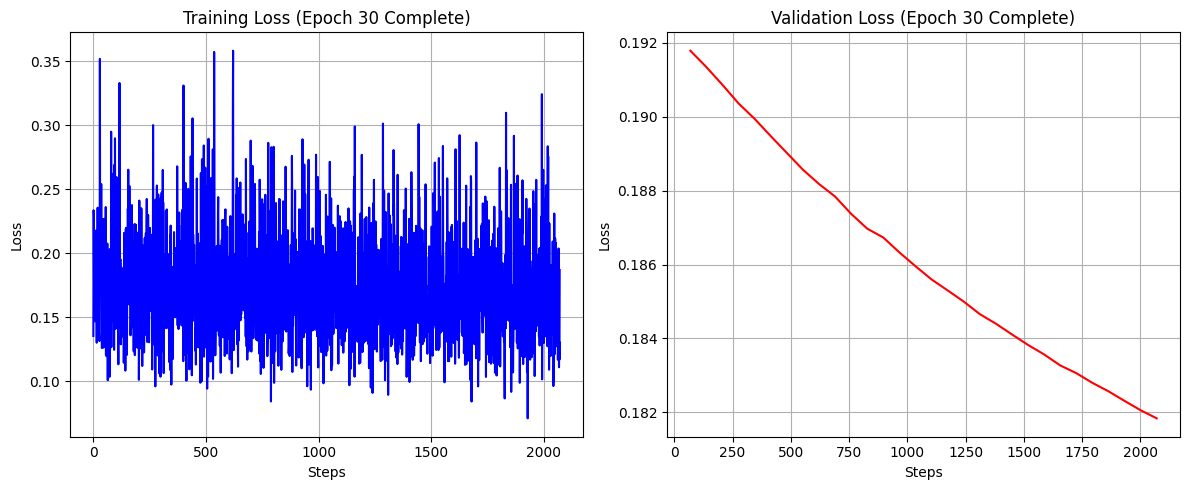

100%|██████████| 30/30 [02:58<00:00,  5.94s/it]

Epoch 30/30 - Train Loss: 0.1868, Val Loss: 0.1818


In [ ]:
# binary cross entropy loss
def weighted_bce_loss(predictions, targets, lengths, weight_for_1=500.0):
    # Standard BCE loss (without reduction)
    loss = nn.BCEWithLogitsLoss(reduction='none')(predictions, targets)
    
    # Create weights: 1.0 for class 0, weight_for_1 for class 1
    weights = targets * (weight_for_1 - 1.0) + 1.0

    # Apply mask to zero out loss for padding tokens
    mask = torch.zeros_like(loss)
    for i, length in enumerate(lengths):
        mask[i, :length] = 1
    mask = mask.bool()
    loss = loss * mask
    
    # Apply weights and take mean
    weighted_loss = (loss * weights).mean()
    return weighted_loss

def dice_loss(predictions, targets, lengths):
    # Apply sigmoid activation to get probabilities
    predictions = torch.sigmoid(predictions)

    # Apply mask to zero out loss for padding tokens
    mask = torch.zeros_like(predictions)
    for i, length in enumerate(lengths):
        mask[i, :length] = 1
    mask = mask.bool()
    predictions = predictions * mask
    targets = targets * mask

    # Compute intersection and union
    intersection = (predictions * targets).sum(dim=1)
    union = predictions.sum(dim=1) + targets.sum(dim=1)
    
    # Compute DICE loss
    loss = 1 - (2 * intersection + 1) / (union + 1)
    
    return loss.mean()

# criterion = lambda pred, target, lengths: weighted_bce_loss(pred, target, lengths, weight_for_1=penalty_multiplier)
# criterion = FocalLoss(alpha=1.0, gamma=2.0, reduction='mean')
criterion = lambda pred, target, lengths: FocalLoss(alpha=1.0, gamma=2.0, reduction='mean')(pred, target, lengths) + weighted_bce_loss(pred, target, lengths, weight_for_1=penalty_multiplier)
# classifier = RetrievalMatchingModel(embedding_dim=encoded_dim, hidden_dim=256, dropout=0.3).to(device)
classifier = SimpleRetrievalModel(embedding_dim=encoded_dim, hidden_dim=256, dropout=0.3).to(device)
classifier = SimilarityBasedRetrieval(embedding_dim=encoded_dim, hidden_dim=256, dropout=0.3).to(device)
optimizer = optim.AdamW(classifier.parameters(), lr=5e-5)
epochs = 100

train_losses = []
val_losses = []
train_steps = []
val_steps = []
step = 0

for epoch in tqdm(range(epochs)):

    classifier.train()    
    for batch in train_loader:
        step += 1
        query = batch['query'].to(device)
        utterances = batch['utterances'].to(device)
        lengths = batch['length'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = classifier(query, utterances, lengths)
        loss = criterion(outputs, labels, lengths)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_steps.append(step)

        # Plot training progress every few steps
        if step % 5 == 0:  # Adjust frequency as needed
            clear_output(wait=True)
            plt.figure(figsize=(12, 5))
            
            # Training plot
            plt.subplot(1, 2, 1)
            plt.plot(train_steps, train_losses, 'b-')
            plt.title(f'Training Loss (Epoch {epoch+1})')
            plt.xlabel("Steps")
            plt.ylabel("Loss")
            plt.grid(True)
            
            # Validation plot
            plt.subplot(1, 2, 2)
            plt.plot(val_steps, val_losses, 'r-')
            plt.title(f'Validation Loss (Epoch {epoch+1})')
            plt.xlabel("Steps")
            plt.ylabel("Loss")
            plt.grid(True)
            
            plt.tight_layout()
            plt.show()

    classifier.eval()
    with torch.no_grad():
        classifier.eval()
        val_epoch_losses = []
        for batch in val_loader:
            query = batch['query'].to(device)
            utterances = batch['utterances'].to(device)
            lengths = batch['length'].to(device)
            labels = batch['labels'].to(device)

            outputs = classifier(query, utterances, lengths)
            loss = criterion(outputs, labels, lengths)

            val_epoch_losses.append(loss.item())

    avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
    val_losses.append(avg_val_loss)
    val_steps.append(step)
            
    # Plot final state at the end of each epoch
    clear_output(wait=True)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_steps, train_losses, 'b-')
    plt.title(f'Training Loss (Epoch {epoch+1} Complete)')
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(val_steps, val_losses, 'r-')
    plt.title(f'Validation Loss (Epoch {epoch+1} Complete)')
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


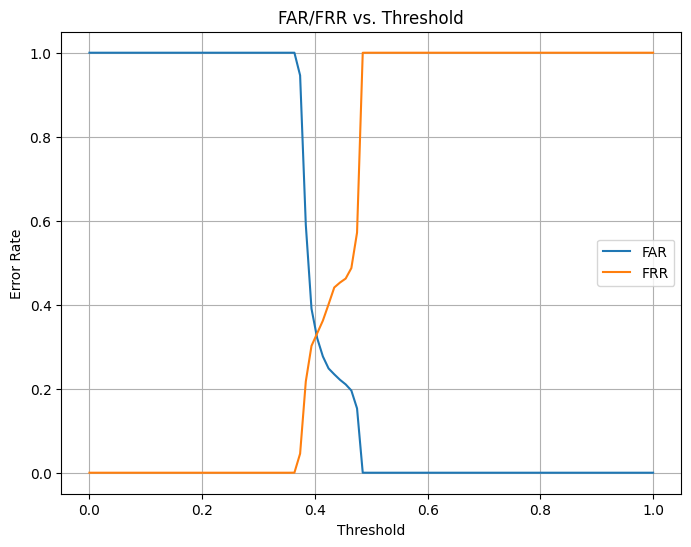

In [ ]:
test_probs = np.array([])
test_labels = np.array([])
for batch in test_loader:
    query = batch['query'].to(device)
    utterances = batch['utterances'].to(device)
    lengths = batch['length'].to(device)
    labels = batch['labels'].to(device)

    probs = classifier.predict_proba(query, utterances, lengths).cpu().detach().numpy()
    labels = labels.cpu().numpy()

    mask = np.zeros_like(probs)
    for i, length in enumerate(lengths):
        mask[i, :length] = 1
    mask = mask.astype(bool)
    probs = probs[mask]
    labels = labels[mask]

    test_probs = np.concatenate([test_probs, probs.flatten()])
    test_labels = np.concatenate([test_labels, labels.flatten()])

far = []
frr = []

thresholds = np.linspace(0, 1, 100)
for threshold in thresholds:
    preds = (test_probs > threshold).astype(int)
    tp = np.sum((preds == 1) & (test_labels == 1))
    tn = np.sum((preds == 0) & (test_labels == 0))
    fp = np.sum((preds == 1) & (test_labels == 0))
    fn = np.sum((preds == 0) & (test_labels == 1))

    far.append(fp / (fp + tn))
    frr.append(fn / (fn + tp))

plt.figure(figsize=(8, 6))
plt.plot(thresholds, far, label="FAR")
plt.plot(thresholds, frr, label="FRR")
plt.xlabel("Threshold")
plt.ylabel("Error Rate")
plt.title("FAR/FRR vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
threshold = 0.4

preds = (test_probs > threshold).astype(int)
tp = np.sum((preds == 1) & (test_labels == 1))
tn = np.sum((preds == 0) & (test_labels == 0))
fp = np.sum((preds == 1) & (test_labels == 0))
fn = np.sum((preds == 0) & (test_labels == 1))

print(f"Recall: {tp / (tp + fn):.4f}")
print(f"Precision: {tp / (tp + fp):.4f}")
print(f"Accuracy: {(tp + tn) / len(test_labels):.4f}")
print(f"F1 Score: {2 * tp / (2 * tp + fp + fn):.4f}")

Recall: 0.6819
Precision: 0.1814
Accuracy: 0.6587
F1 Score: 0.2866


In [ ]:
print((test_probs > threshold).astype(int)[100:200])
print(test_labels.astype(int)[100:200])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# Save the model
torch.save(classifier.state_dict(), "classifier_model.pth")